In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from diffusers import DDPMScheduler
import random

# Training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
epochs = 1000
diffusion_timesteps = 100
dim = 3

/home/yishul/miniconda3/envs/eais/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Diffusion model

In [2]:
# Define the diffusion model
class OneHotDiffusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.timestep_embed = nn.Embedding(diffusion_timesteps, 16)
        self.net = nn.Sequential(
            nn.Linear(dim + 16, 128),
            nn.SiLU(),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, dim)
        )
        
    def forward(self, x, t):
        t_embed = self.timestep_embed(t).squeeze(1)
        x = torch.cat([x, t_embed], dim=1)
        return self.net(x)

# Create synthetic dataset of one-hot vectors
class OneHotDataset(Dataset):
    def __init__(self, size=10000):
        self.size = size
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        vec = torch.zeros(dim)
        vec[random.randint(0, dim-2)] = 1.0   # exclude the last mode
        return vec

- Sampling utils

In [3]:
# Sampling function
def generate_sample(model, scheduler, bsz=10):
    model.eval()
    with torch.no_grad():
        # Start with random noise
        x = torch.randn((bsz, dim)).to(device)
        
        # Denoising loop
        for t in scheduler.timesteps:
            timestep = torch.tensor([t] * bsz, device=device)
            noise_pred = model(x, timestep)
            x = scheduler.step(noise_pred, t, x).prev_sample
        
        # Convert to one-hot
        probs = F.softmax(x, dim=-1)
        sample = torch.argmax(probs, dim=-1)
        return F.one_hot(sample, num_classes=dim).squeeze().cpu().numpy()
    

def generate_and_analyze_samples(model, scheduler, num_samples=10000):
    model.eval()
    with torch.no_grad():
        # Generate multiple samples at once using batch processing
        x = torch.randn((num_samples, dim)).to(device)
        
        # Denoising loop (same as before but processes all samples simultaneously)
        for t in scheduler.timesteps:
            timestep = torch.tensor([t], device=device).repeat(num_samples)
            noise_pred = model(x, timestep)
            x = scheduler.step(noise_pred, t, x).prev_sample
        
        # Convert to categorical distribution
        probs = F.softmax(x, dim=-1)
        categories = torch.argmax(probs, dim=-1)
        
        # Convert to one-hot vectors
        one_hot_samples = F.one_hot(categories, num_classes=dim)
        
        # Calculate statistics
        counts = torch.bincount(categories, minlength=dim)
        stats = {
            f"Category {i}": count.item() 
            for i, count in enumerate(counts)
        }
        
        return {
            "samples": one_hot_samples.cpu().numpy(),
            "statistics": stats,
            "counts": counts.cpu().numpy()
        }

# Step 0: Train an Unconditional Diffusion

- Train the model

In [43]:
# Train the model
scheduler = DDPMScheduler(num_train_timesteps=diffusion_timesteps, beta_schedule="linear")
model = OneHotDiffusionModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dataset = OneHotDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
model.train()
for epoch in range(epochs):
    for batch in dataloader:
        # Prepare data
        clean_data = batch.to(device)
        noise = torch.randn_like(clean_data)
        
        # Sample random timesteps
        timesteps = torch.randint(
            0, scheduler.num_train_timesteps, 
            (clean_data.shape[0],), device=device
        ).long()
        
        # Add noise using scheduler
        noisy_data = scheduler.add_noise(clean_data, noise, timesteps)
        
        # Predict noise
        noise_pred = model(noisy_data, timesteps)
        
        # Calculate loss
        loss = F.mse_loss(noise_pred, noise)
        
        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item():.4f}")

/home/yishul/miniconda3/envs/eais/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 1/1000 Loss: 0.5866
Epoch 2/1000 Loss: 0.4940
Epoch 3/1000 Loss: 0.6652
Epoch 4/1000 Loss: 0.2852
Epoch 5/1000 Loss: 0.2522
Epoch 6/1000 Loss: 0.1636
Epoch 7/1000 Loss: 0.5530
Epoch 8/1000 Loss: 0.1956
Epoch 9/1000 Loss: 0.2823
Epoch 10/1000 Loss: 0.2502
Epoch 11/1000 Loss: 0.2086
Epoch 12/1000 Loss: 0.3903
Epoch 13/1000 Loss: 0.4961
Epoch 14/1000 Loss: 0.4943
Epoch 15/1000 Loss: 0.2029
Epoch 16/1000 Loss: 0.2318
Epoch 17/1000 Loss: 0.2375
Epoch 18/1000 Loss: 0.1435
Epoch 19/1000 Loss: 0.1689
Epoch 20/1000 Loss: 0.3290
Epoch 21/1000 Loss: 0.2121
Epoch 22/1000 Loss: 0.1811
Epoch 23/1000 Loss: 0.1094
Epoch 24/1000 Loss: 0.1040
Epoch 25/1000 Loss: 0.1011
Epoch 26/1000 Loss: 0.0689
Epoch 27/1000 Loss: 0.1933
Epoch 28/1000 Loss: 0.3659
Epoch 29/1000 Loss: 0.1410
Epoch 30/1000 Loss: 0.0831
Epoch 31/1000 Loss: 0.1133
Epoch 32/1000 Loss: 0.0757
Epoch 33/1000 Loss: 0.0821
Epoch 34/1000 Loss: 0.4685
Epoch 35/1000 Loss: 0.4192
Epoch 36/1000 Loss: 0.3563
Epoch 37/1000 Loss: 0.1017
Epoch 38/1

- Save the model

In [44]:
torch.save(model.state_dict(), "one_hot_diffusion.pth")

- Check the Unconditional Distribution

In [45]:
# # Generate a sample
# print("Generated sample:", generate_sample(model, scheduler))

# Generate and analyze samples
results = generate_and_analyze_samples(model, scheduler, num_samples=10000)
print("Sample statistics:")
for k, v in results["statistics"].items():
    print(f"{k}: {v} ({v/100}%)")

# Example output:
# Category 0: 253 (25.3%)
# Category 1: 246 (24.6%)
# Category 2: 251 (25.1%)
# Category 3: 250 (25.0%)

Sample statistics:
Category 0: 5005 (50.05%)
Category 1: 4995 (49.95%)
Category 2: 0 (0.0%)


# Step 1: Train a safety policy

- Define & Load Pretrained Diffusion Model

In [4]:
scheduler = DDPMScheduler(num_train_timesteps=diffusion_timesteps, beta_schedule="linear")
diffusion_model = OneHotDiffusionModel().to(device)

checkpoint = torch.load("one_hot_diffusion.pth")
diffusion_model.load_state_dict(checkpoint)

<All keys matched successfully>

- Define Safety Actor Critic Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from diffusers import DDPMScheduler
from collections import defaultdict

class SafetyController(nn.Module):
    """Actor: Produces safety correction actions"""
    def __init__(self):
        super().__init__()
        self.timestep_embed = nn.Embedding(diffusion_timesteps, 32)
        self.net = nn.Sequential(
            nn.Linear(dim + 32, 256),
            nn.LayerNorm(256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.LayerNorm(256),
            nn.SiLU(),
            nn.Linear(256, dim)  # Mean
        )
        self.log_std = nn.Parameter(torch.zeros(dim) - 1.0, requires_grad=True)
        
    def forward(self, x, t):
        t_embed = self.timestep_embed(t).squeeze(1)
        x = torch.cat([x, t_embed], dim=1)
        mean = self.net(x)
        # print("X:", x, "Mean:", mean)
        return mean, self.log_std.exp()  # Return (mean, std)
    
def get_action(mean, std):
    normal_dist = torch.distributions.Normal(mean, std)
    action = normal_dist.rsample()  # Reparameterized sampling
    return action

def log_prob(mean, std, action):
    # Add numerical stability safeguards
    min_std = 1e-4  # Minimum standard deviation to prevent underflow
    clamped_std = std.clamp(min=min_std)
    
    # Create distribution with safe parameters
    normal_dist = torch.distributions.Normal(
        loc=mean,
        scale=clamped_std
    )
    
    # Calculate log probs with stability
    log_probs = normal_dist.log_prob(action)
    
    # Sum across action dimensions (-1)
    return log_probs.sum(dim=-1)

class SafetyCritic(nn.Module):
    """Critic: Predicts expected return for state-timestep pairs"""
    def __init__(self):
        super().__init__()
        self.timestep_embed = nn.Embedding(diffusion_timesteps, 32)
        self.net = nn.Sequential(
            nn.Linear(dim + 32, 256),
            nn.SiLU(),
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Linear(128, 1)  # Outputs value estimate
        )
        
    def forward(self, x, t):
        t_embed = self.timestep_embed(t)
        # print(x.shape, t_embed.shape)
        return self.net(torch.cat([x, t_embed], dim=1))

# 2. Training Class -----------------------------------------------------------
class SafetyTrainer:
    def __init__(self, diffusion_model, scheduler, unsafe_state=[1, 0, 0]):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.diffusion_model = diffusion_model.to(self.device)
        self.scheduler = scheduler
        self.unsafe_state = unsafe_state
        
        # Initialize networks
        self.controller = SafetyController().to(self.device)
        self.critic = SafetyCritic().to(self.device)
        
        # Optimizers
        self.ctrl_optim = optim.Adam(self.controller.parameters(), lr=1e-4)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=1e-4)
        
        # Hyperparameters
        self.gamma = 0.99  # Discount factor
    
    def _is_unsafe(self, state):
        """Check if state is unsafe (one-hot [1,0,0])"""
        probs = F.softmax(state, dim=-1)
        categories = torch.argmax(probs, dim=-1)
        one_hot_samples = F.one_hot(categories, num_classes=dim)
        return torch.all(torch.eq(one_hot_samples.to(self.device), torch.tensor(self.unsafe_state).to(self.device)), dim=-1)
    
    def _compute_returns(self, rewards):
        """Monte Carlo returns with discounting"""
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        return torch.tensor(returns, device=self.device).float()
    

    def collect_trajectories(self, num_traj=100):
        """Batched trajectory collection"""
        # Initialize all trajectories simultaneously
        x = torch.randn(num_traj, dim).to(self.device)
        batch_trajectories = defaultdict(list)
        
        # Store all steps for all trajectories
        all_states = []
        all_timesteps = []
        all_interventions = []
        all_value_ests = []
        
        for t in self.scheduler.timesteps:
            # Process entire batch at once
            timestep = torch.full((num_traj,), t, device=self.device)
            
            with torch.no_grad():
                # Get actions for all trajectories
                nominal_actions = self.diffusion_model(x, timestep)
                safety_mean, safety_std = self.controller(x, timestep)
                value_ests = self.critic(x, timestep)
                
                # Sample safety actions
                normal_dist = torch.distributions.Normal(safety_mean, safety_std)
                safety_actions = normal_dist.rsample()
                
                # Intervention decisions
                intervene_mask = (value_ests < -0.5).squeeze()
                
                # Combine actions
                actions = torch.where(intervene_mask.unsqueeze(-1), 
                                    safety_actions, 
                                    nominal_actions)
                
                # Step diffusion process
                x = self.scheduler.step(actions, t, x).prev_sample
                
            # Store batch data
            all_states.append(x.clone())
            all_timesteps.append(timestep.clone())
            all_interventions.append(intervene_mask)
            all_value_ests.append(value_ests)
        
        # Convert to tensors
        states = torch.stack(all_states)  # [num_steps, batch_size, dim]
        timesteps = torch.stack(all_timesteps)  # [num_steps, batch_size]
        interventions = torch.stack(all_interventions)  # [num_steps, batch_size]
        value_ests = torch.stack(all_value_ests)  # [num_steps, batch_size, 1]
        
        # Get final rewards
        final_unsafe = self._is_unsafe(x)
        final_rewards = -final_unsafe.float().squeeze()
        
        # Reorganize into individual trajectories
        trajs = []
        for i in range(num_traj):
            transitions = []
            for step in range(len(self.scheduler.timesteps)):
                transitions.append({
                    'state': states[step, i],
                    'timestep': timesteps[step, i],
                    'intervened': interventions[step, i].item(),
                    'value_est': value_ests[step, i]
                })
            # Assign final reward to last step
            transitions[-1]['reward'] = final_rewards[i].item()
            
            trajs.append({
                'transitions': transitions,
                'reward': final_rewards[i].item()
            })
        
        return trajs
    

    def train(self, epochs=100, batch_size=32):
        for epoch in range(epochs):
            # Collect trajectories (with complete state/timestep records)
            trajs = self.collect_trajectories(batch_size)
            
            # Process trajectories
            all_states = []
            all_timesteps = []
            all_returns = []
            all_interventions = []
            
            for traj in trajs:
                # Compute returns (non-differentiable)
                rewards = [0] * (len(traj['transitions']) - 1) + [traj['reward']]
                returns = self._compute_returns(rewards)
                
                # Collect states and timesteps
                for i, transition in enumerate(traj['transitions']):
                    all_states.append(transition['state'].squeeze(0))
                    all_timesteps.append(transition['timestep'].squeeze(0))
                    all_returns.append(returns[i])
                    all_interventions.append(transition['intervened'])
            
            # Convert to tensors
            states = torch.stack(all_states)
            timesteps = torch.stack(all_timesteps)
            returns = torch.stack(all_returns)
            
            # 1. Train Critic (differentiable forward pass)
            current_values = self.critic(states, timesteps).squeeze()
            print(current_values, returns)
            critic_loss = F.mse_loss(current_values, returns)
            
            self.critic_optim.zero_grad()
            critic_loss.backward()
            self.critic_optim.step()

            loss = 0
            
            # 2. Train Controller (only on intervention points)
            if sum(all_interventions) > 0:
                # Filter to intervention points
                intv_mask = torch.tensor(all_interventions, device=self.device)
                intv_states = states[intv_mask]
                intv_timesteps = timesteps[intv_mask]
                intv_returns = returns[intv_mask]
                
                # Calculate advantages
                with torch.no_grad():
                    intv_values = self.critic(intv_states, intv_timesteps).squeeze()
                advantages = intv_returns - intv_values   # If the safe policy increase the return?
                # advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
                
                # Policy gradient update
                mean, std = self.controller(intv_states, intv_timesteps)
                actions = get_action(mean, std)
                log_probs = log_prob(mean, std, actions)

                loss = -(advantages * log_probs).mean()  # policy gradient
                
                # Add after backward():
                torch.nn.utils.clip_grad_norm_(self.controller.parameters(), 1.0)
                self.ctrl_optim.zero_grad()
                loss.backward()
                self.ctrl_optim.step()
            
            # Logging
            unsafe_rate = sum(t['reward'] for t in trajs) / batch_size
            print(f"Epoch {epoch+1}/{epochs} | Critic Loss: {critic_loss} | Controller Loss: {loss} | Unsafe Rate: {-unsafe_rate:.3f}")


# 3. Usage ---------------------------------------------------------------------
# Initialize components
trainer = SafetyTrainer(diffusion_model, scheduler)

In [ ]:
# torch.save(trainer.state_dict(), "safe_controller.pth")

- Training

In [68]:
# Training
trainer.train(epochs=100, batch_size=128)

tensor([-0.0056, -0.0435,  0.0446,  ..., -0.0266, -0.0633, -0.0434],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
Epoch 1/100 | Critic Loss: 0.2681463956832886 | Controller Loss: 0 | Unsafe Rate: 0.562
tensor([-0.0025, -0.0554,  0.0422,  ..., -0.0332, -0.0656, -0.0504],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
Epoch 2/100 | Critic Loss: 0.25165829062461853 | Controller Loss: 0 | Unsafe Rate: 0.539
tensor([-0.0200, -0.0719,  0.0260,  ..., -0.0401, -0.0681, -0.0574],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
Epoch 3/100 | Critic Loss: 0.1933407336473465 | Controller Loss: 0 | Unsafe Rate: 0.422
tensor([-0.0360, -0.0781,  0.0066,  ..., -0.0471, -0.0705, -0.0644],
       device='cuda:0', grad_fn=<SqueezeBackward0>) tensor([-0.3697, -0.3735, -0.3772,  ...,  0.0000,  0.0000,  0.0000],
       device=

In [ ]:
# def train(self, epochs=100, batch_size=32):
    #     for epoch in range(epochs):
    #         # Collect trajectories
    #         trajs = self.collect_trajectories(batch_size)
            
    #         # Process trajectories
    #         all_returns = []
    #         all_values = []
    #         all_actions = []
            
    #         for traj in trajs:
    #             # Compute returns for each timestep
    #             rewards = [traj['reward']] * len(traj['transitions'])
    #             returns = self._compute_returns(rewards)
                
    #             # Collect training data
    #             for i, transition in enumerate(traj['transitions']):
    #                 all_returns.append(returns[i])
    #                 all_values.append(transition['value_est'])
    #                 if transition['intervened']:
    #                     all_actions.append((
    #                         transition['state'],
    #                         transition['timestep']
    #                     ))
            
    #         # Convert to tensors (handle empty cases)
    #         returns_tensor = torch.stack(all_returns) if all_returns else None
    #         values_tensor = torch.stack(all_values) if all_values else None
            
    #         # 1. Always train critic if we have any data
    #         if returns_tensor is not None and values_tensor is not None:
    #             critic_loss = F.mse_loss(values_tensor.squeeze(), returns_tensor)
    #             self.critic_optim.zero_grad()
    #             critic_loss.backward()
    #             self.critic_optim.step()
    #         else:
    #             print("No data for critic training")
    #             continue
                
    #         # 2. Only train controller if interventions occurred
    #         if len(all_actions) > 0:
    #             states_tensor = torch.stack([a[0] for a in all_actions])
    #             timesteps_tensor = torch.stack([a[1] for a in all_actions])
                
    #             # Calculate advantages
    #             advantages = returns_tensor - values_tensor.detach()
                
    #             # Get policy outputs for intervention points
    #             actions_pred = self.controller(states_tensor, timesteps_tensor)
                
    #             # Calculate loss
    #             loss = -(advantages * torch.log(F.softmax(actions_pred, dim=-1))).mean()
                
    #             self.ctrl_optim.zero_grad()
    #             loss.backward()
    #             self.ctrl_optim.step()
    #         else:
    #             print("No interventions - controller not updated")
            
    #         # Logging
    #         unsafe_rate = sum(t['reward'] for t in trajs) / batch_size
    #         print(f"Epoch {epoch+1}/{epochs} | Unsafe Rate: {-unsafe_rate:.3f}")

- Deploy the safe controller

In [6]:
# Deployment
def safe_generate(diffusion_model, safety_controller, critic, scheduler, bsz=1):
    x = torch.randn(bsz, dim).to(device)
    for t in scheduler.timesteps:
        timestep = torch.full((bsz,), t, device=device)
        
        with torch.no_grad():
            # Get actions for all samples in batch
            nominal = diffusion_model(x, timestep)
            safety, std = safety_controller(x, timestep)
            values = critic(x, timestep)  # Shape: [bsz, 1]
            
        # Create intervention mask for entire batch
        intervene_mask = (values < -0.5).squeeze(-1)  # [bsz]
        
        # Combine actions using mask
        actions = torch.where(
            intervene_mask.unsqueeze(-1),  # [bsz, 1]
            safety,
            nominal
        )
        
        # Update all samples in batch simultaneously
        x = scheduler.step(actions, t, x).prev_sample
    
    # Convert to one-hot and return
    return F.one_hot(x.argmax(-1), num_classes=4)

# Analyze Results

- Inference

In [7]:
trainer.controller.load_state_dict(torch.load("latest_safe_controller.pth"))
trainer.critic.load_state_dict(torch.load("latest_safe_critic.pth"))

<All keys matched successfully>

In [8]:
# Generate and analyze samples
results = generate_and_analyze_samples(diffusion_model, scheduler, num_samples=10000)
print("Sample statistics:")
for k, v in results["statistics"].items():
    print(f"{k}: {v} ({v/100}%)")

Sample statistics:
Category 0: 4925 (49.25%)
Category 1: 5075 (50.75%)
Category 2: 0 (0.0%)


In [9]:
from tqdm import tqdm
import numpy as np
categories = []
categories = safe_generate(diffusion_model, trainer.controller, trainer.critic, scheduler, bsz=10000)

print(categories.shape)
# categories = torch.stack(categories)
counts = torch.bincount(torch.argmax(categories, dim=-1), minlength=3)
stats = {
    f"Category {i}": count.item() 
    for i, count in enumerate(counts)
}

print("Sample statistics:")
for k, v in stats.items():
    print(f"{k}: {v} ({v/100}%)")

torch.Size([10000, 4])
Sample statistics:
Category 0: 4424 (44.24%)
Category 1: 5437 (54.37%)
Category 2: 139 (1.39%)


100%|██████████| 40/40 [00:07<00:00,  5.63it/s]


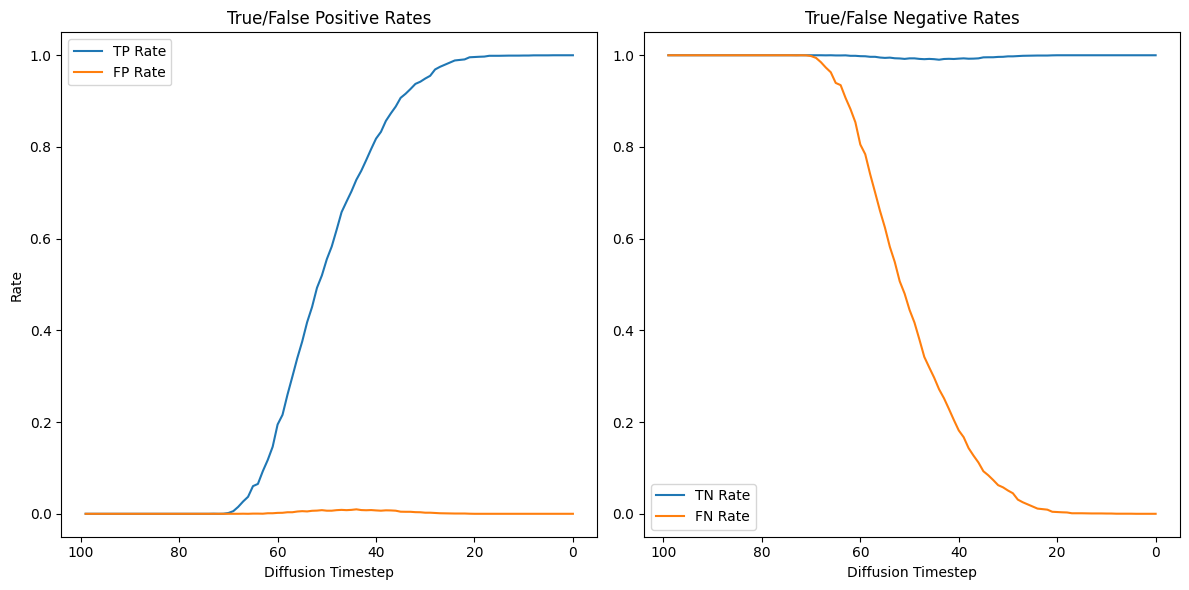

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def collect_critic_data(safety_trainer, num_trajectories=10000):
    """Collect states, critic values, and final outcomes"""
    all_states = []
    all_timesteps = []
    all_values = []
    all_unsafe = []
    
    device = safety_trainer.device
    
    # Generate in batches for efficiency
    batch_size = 256
    num_batches = int(np.ceil(num_trajectories / batch_size))
    
    with torch.no_grad():
        for _ in tqdm(range(num_batches)):
            # Generate batch
            x = torch.randn(batch_size, dim).to(device)
            batch_states = []
            batch_values = []
            
            # Run through diffusion process
            for t in safety_trainer.scheduler.timesteps:
                timestep = torch.full((batch_size,), t, device=device)
                
                # Store states and values
                value = safety_trainer.critic(x, timestep)
                batch_states.append(x.cpu().numpy())
                batch_values.append(value.cpu().numpy())
                
                # Step diffusion
                nominal = safety_trainer.diffusion_model(x, timestep)
                x = safety_trainer.scheduler.step(nominal, t, x).prev_sample
            
            # Get final outcomes
            final_unsafe = safety_trainer._is_unsafe(x).cpu().numpy()
            
            # Reorganize data
            for i in range(batch_size):
                all_states.extend([batch_states[t][i] for t in range(len(safety_trainer.scheduler.timesteps))])
                all_timesteps.extend(safety_trainer.scheduler.timesteps)
                all_values.extend([batch_values[t][i] for t in range(len(safety_trainer.scheduler.timesteps))])
                all_unsafe.extend([final_unsafe[i]] * len(safety_trainer.scheduler.timesteps))
    
    return {
        'states': np.array(all_states),
        'timesteps': np.array(all_timesteps),
        'values': np.array(all_values).squeeze(),
        'unsafe': np.array(all_unsafe)
    }

def analyze_critic(data, threshold=-0.5):
    """Calculate classification metrics per timestep"""
    timesteps = np.unique(data['timesteps'])
    metrics = {t: {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0} for t in timesteps}
    
    for t in timesteps:
        mask = data['timesteps'] == t
        values = data['values'][mask]
        unsafe = data['unsafe'][mask]
        
        # Predictions (positive = unsafe prediction)
        preds = values < threshold
        
        # Calculate confusion matrix
        metrics[t]['TP'] = np.sum(preds & unsafe)
        metrics[t]['FP'] = np.sum(preds & ~unsafe)
        metrics[t]['TN'] = np.sum(~preds & ~unsafe)
        metrics[t]['FN'] = np.sum(~preds & unsafe)
        
    return metrics

def plot_metrics(metrics, scheduler):
    """Plot metrics over diffusion steps"""
    timesteps = sorted(metrics.keys(), reverse=True)  # From noise to clean
    steps = scheduler.timesteps.cpu().numpy()
    
    # Convert to rates
    tp_rate = [metrics[t]['TP']/(metrics[t]['TP']+metrics[t]['FN']) if (metrics[t]['TP']+metrics[t]['FN']) > 0 else 0 for t in timesteps]
    fp_rate = [metrics[t]['FP']/(metrics[t]['FP']+metrics[t]['TN']) if (metrics[t]['FP']+metrics[t]['TN']) > 0 else 0 for t in timesteps]
    tn_rate = [metrics[t]['TN']/(metrics[t]['TN']+metrics[t]['FP']) if (metrics[t]['TN']+metrics[t]['FP']) > 0 else 0 for t in timesteps]
    fn_rate = [metrics[t]['FN']/(metrics[t]['TP']+metrics[t]['FN']) if (metrics[t]['TP']+metrics[t]['FN']) > 0 else 0 for t in timesteps]

    plt.figure(figsize=(12, 6))
    
    # Plot 1: TP/FP Rates
    plt.subplot(1, 2, 1)
    plt.plot(steps, tp_rate, label='TP Rate')
    plt.plot(steps, fp_rate, label='FP Rate')
    plt.title('True/False Positive Rates')
    plt.xlabel('Diffusion Timestep')
    plt.ylabel('Rate')
    plt.gca().invert_xaxis()  # Reverse to show denoising progression
    plt.legend()
    
    # Plot 2: TN/FN Rates
    plt.subplot(1, 2, 2)
    plt.plot(steps, tn_rate, label='TN Rate')
    plt.plot(steps, fn_rate, label='FN Rate')
    plt.title('True/False Negative Rates')
    plt.xlabel('Diffusion Timestep')
    plt.gca().invert_xaxis()
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Usage
data = collect_critic_data(trainer, num_trajectories=10000)
metrics = analyze_critic(data)
plot_metrics(metrics, scheduler)